# PowerGAMA
Example based on a modified 9-bus case

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import powergama
import powergama.plots as ppl
import numpy as np
import time
import matplotlib.pyplot as plt
import folium

# Alternative 1: Use example data bundled with the package
import pathlib
#pathbase=os.path.split(powergama.__path__[0])[0]
#datapath=str(os.path.join(pathbase,'examples','data','9busmod_'))
#datapath=str(os.path.join(os.path.,'examples','data','9busmod_'))
datapath = pathlib.Path(pathlib.Path().parent/"test_data/data_9bus")


# Specity time range for simulation
timerange=range(24*100,24*100+24*2)

data = powergama.GridData()
data.readGridData(nodes=datapath/"9busmod_nodes.csv",
                  ac_branches=datapath/"9busmod_branches.csv",
                  dc_branches=None,
                  generators=datapath/"9busmod_generators.csv",
                  consumers=datapath/"9busmod_consumers.csv")
data.readProfileData(filename=datapath/"9busmod_profiles.csv",
            storagevalue_filling=datapath/"9busmod_profiles_storval_filling.csv",
            storagevalue_time=datapath/"9busmod_profiles_storval_time.csv",
            timerange=timerange, 
            timedelta=1.0)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
powergama.__path__

['C:\\Users\\hsven\\code\\powergama\\src\\powergama']

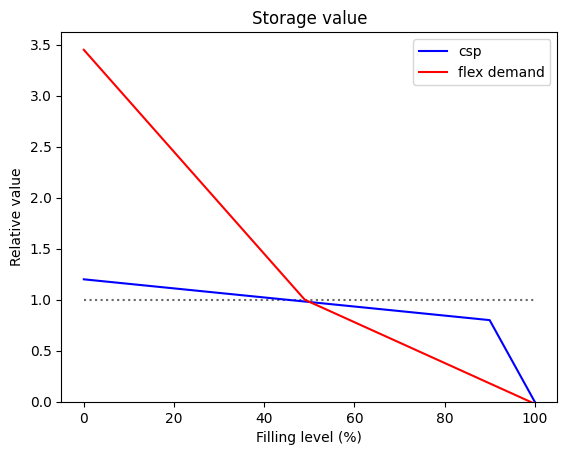

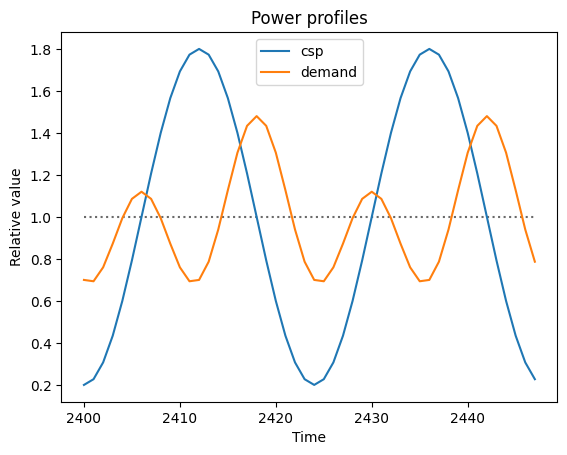

In [7]:
# Plots of input

plt.figure()
plt.plot([0,100],[1,1],linestyle=':',color='dimgray')
plt.plot(data.storagevalue_filling['csp2'],color='blue',label='csp')
plt.plot(data.storagevalue_filling['flexdemand'],color='red',
         label='flex demand')
plt.xlabel('Filling level (%)')
plt.ylabel('Relative value')
plt.ylim(ymin=0)
plt.legend()
plt.title("Storage value")

plt.figure()
plt.plot([timerange[0],timerange[-1]],[1,1],linestyle=':',color='dimgray')
plt.plot(timerange,data.storagevalue_time['csp2'],label='csp')
plt.legend()
#ax2=plt.twinx()
plt.plot(timerange,data.profiles['demand2'],label='demand')
plt.xlabel('Time')
plt.ylabel('Relative value')
plt.legend()
plt.title("Power profiles")
plt.show()

### Case 0

Computing B and DA matrices...
Creating B and DA coefficients...
Found synchronous area (size = 9), using ref node = bus1
Creating LP problem instance...
Initialising LP problem...
Replacing existing SQLite file "c:\Users\hsven\code\powergama\tests\results.sqlite3"
:) Using direct python interface to solver
Solving...
2% 4% 6% 8% 10% 12% 14% 16% 18% 20% 22% 25% 27% 29% 31% 33% 35% 37% 39% 41% 43% 45% 47% 50% 52% 54% 56% 58% 60% 62% 64% 66% 68% 70% 72% 75% 77% 79% 81% 83% 85% 87% 89% 91% 93% 95% 97% 100% 
Simulation time = 0.97 seconds
System costs (CASE 1) = 9.17e+04 EUR
Load shedding = 0.00e+00
Spilled CSP inflow = 0.00e+00


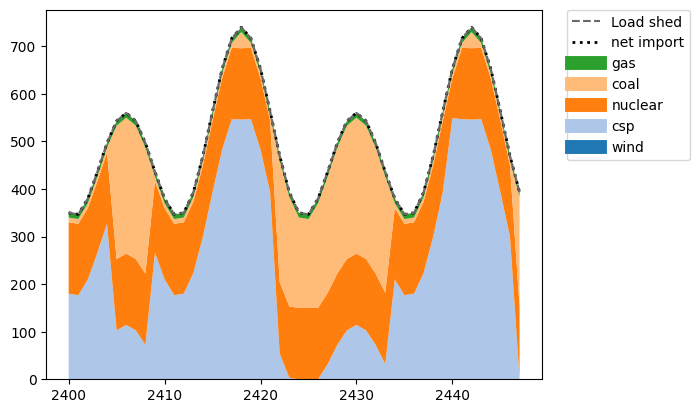

In [12]:
# CASE 0: Base

# Increased generation capacity
data.generator.loc[1,'pmax']=150 # Instead of default=50 (nuclear)
data.generator.loc[3,'pmax']=0 # No wind

lp = powergama.LpProblem(data,lossmethod=1)
res = powergama.Results(data,"results.sqlite3",replace=True)

start_time = time.time()
lp.solve(res, solver="gurobi")
end_time = time.time()
print("\nSimulation time = {:.2f} seconds".format(end_time - start_time))

systemcost = res.getSystemCost()['AREA']
print("System costs (CASE 1) = {:.2e} EUR".format(systemcost))
print("Load shedding = {:.2e}".format(sum(res.getLoadheddingInArea('AREA'))))
print("Spilled CSP inflow = {:.2e}".format(
                                    sum(res.getGeneratorSpilled(4))))
res.plotGenerationPerArea('AREA',fill=True,showTitle=False)

#res.plotMapGrid(nodetype='nodalprice',branchtype='sensitivity',
#                show_node_labels=True,dotsize=100,draw_par_mer=False,
#                showTitle=False)

In [11]:
ppl.plotMap(data,res,nodetype='nodalprice',branchtype='sensitivity')

### Case 2: CSP without storage

Computing B and DA matrices...
Creating B and DA coefficients...
Found synchronous area (size = 9), using ref node = bus1
Creating LP problem instance...
Initialising LP problem...
Replacing existing SQLite file "c:\Users\hsven\code\powergama\tests\results.sqlite3"
:) Found solver here: C:\Users\hsven\bin\cbc.exe
Solving...
2% 4% 6% 8% 10% 12% 14% 16% 18% 20% 22% 25% 27% 29% 31% 33% 35% 37% 39% 41% 43% 45% 47% 50% 52% 54% 56% 58% 60% 62% 64% 66% 68% 70% 72% 75% 77% 79% 81% 83% 85% 87% 89% 91% 93% 95% 97% 100% 
Simulation time = 3.01 seconds
System costs (CASE 2) = 1.64e+05 EUR
Load shedding = 3.45e+02
Spilled CSP inflow = 2.89e+03


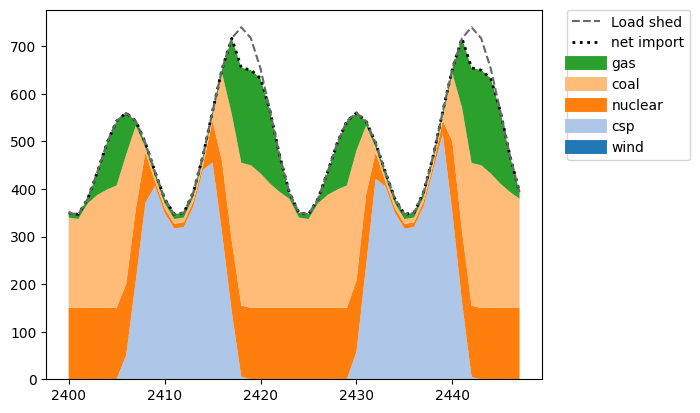

In [13]:
# CASE 2: CSP without storage

#data.generator.set_value(4,'pmax',600) # Instead of default=60 (csp)
data.generator.loc[4,'storage_cap']=0 # No storage

lp = powergama.LpProblem(data)
res = powergama.Results(data,"results.sqlite3",replace=True)

start_time = time.time()
lp.solve(res)
end_time = time.time()
print("\nSimulation time = {:.2f} seconds".format(end_time - start_time))

systemcost = res.getSystemCost()['AREA']
print("System costs (CASE 2) = {:.2e} EUR".format(systemcost))
print("Load shedding = {:.2e}".format(sum(res.getLoadheddingInArea('AREA'))))
print("Spilled CSP inflow = {:.2e}".format(
                                    sum(res.getGeneratorSpilled(4))))

res.plotGenerationPerArea('AREA',fill=True,showTitle=False)


In [6]:
# Requires basemap
#res.plotMapGrid(nodetype='nodalprice',branchtype='sensitivity',
#                show_node_labels=True,dotsize=100,draw_par_mer=False,
#                showTitle=False)
#res.plotMapGrid(nodetype='energybalance',branchtype='utilisation',
#                show_node_labels=True,dotsize=100,draw_par_mer=False,
#                showTitle=False)

# Requires folium
ppl.plotMap(data,res,nodetype='nodalprice',branchtype='sensitivity')


Nodes...
AC branches...
DC branches...
Consumers...
Generators...


In [7]:
ppl.plotMap(data,res,nodetype='energybalance',branchtype='utilisation',
                show_node_labels=True,dotsize=100,draw_par_mer=False,
                showTitle=False)

Nodes...
AC branches...
DC branches...
Consumers...
Generators...


### Case 3: CSP with storage (eliminating load shedding)

Computing B and DA matrices...
Creating B and DA coefficients...
Found synchronous area (size = 9), using ref node = bus1
Creating LP problem instance...
Initialising LP problem...
Replacing existing SQLite file "C:\Users\hsven\code\powergama\powergama\examples\results.sqlite3"
:) Found solver here: c:\users\hsven\bin\cbc.exe
Solving...
2% 4% 6% 8% 10% 12% 14% 16% 18% 20% 22% 25% 27% 29% 31% 33% 35% 37% 39% 41% 43% 45% 47% 50% 52% 54% 56% 58% 60% 62% 64% 66% 68% 70% 72% 75% 77% 79% 81% 83% 85% 87% 89% 91% 93% 95% 97% 100% 
Simulation time = 3.25 seconds
System costs (CASE 3) = 9.17e+04 EUR
Load shedding = 0.00e+00
Spilled CSP inflow = 0.00e+00


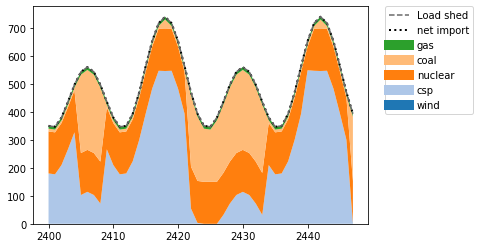

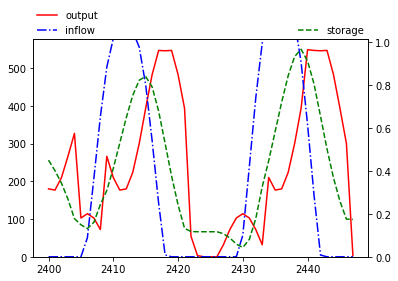

In [8]:
# CASE 3: 

# Increased generation capacity
data.generator.loc[4,'pmax']=600 # Instead of default=60 (csp)
data.generator.loc[4,'storage_cap']=600*6 # back to original
 
lp = powergama.LpProblem(data)
res = powergama.Results(data,"results.sqlite3",replace=True)

start_time = time.time()
lp.solve(res)
end_time = time.time()
print("\nSimulation time = {:.2f} seconds".format(end_time - start_time))

systemcost = res.getSystemCost()['AREA']
print("System costs (CASE 3) = {:.2e} EUR".format(systemcost))
print("Load shedding = {:.2e}".format(sum(res.getLoadheddingInArea('AREA'))))
print("Spilled CSP inflow = {:.2e}".format(
                                    sum(res.getGeneratorSpilled(4))))

res.plotGenerationPerArea('AREA',fill=True,showTitle=False)

res.plotGeneratorOutput(4,showTitle=False)

In [13]:
ppl.plotMap(data,res,nodetype='nodalprice',branchtype='sensitivity')

Nodes...
AC branches...
DC branches...
Consumers...
Generators...


### Case 4: CSP with storage (eliminating load shedding), time-dependent

Computing B and DA matrices...
Creating B and DA coefficients...
Found synchronous area (size = 9), using ref node = bus1
Creating LP problem instance...
Initialising LP problem...
Replacing existing SQLite file "C:\Users\hsven\code\powergama\powergama\examples\results.sqlite3"
:) Found solver here: c:\users\hsven\bin\cbc.exe
Solving...
2% 4% 6% 8% 10% 12% 14% 16% 18% 20% 22% 25% 27% 29% 31% 33% 35% 37% 39% 41% 43% 45% 47% 50% 52% 54% 56% 58% 60% 62% 64% 66% 68% 70% 72% 75% 77% 79% 81% 83% 85% 87% 89% 91% 93% 95% 97% 100% 
Simulation time = 3.06 seconds
System costs (CASE 4) = 9.17e+04 EUR
Load shedding = 0.00e+00
Spilled CSP inflow = 0.00e+00


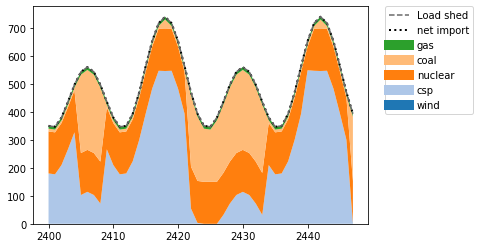

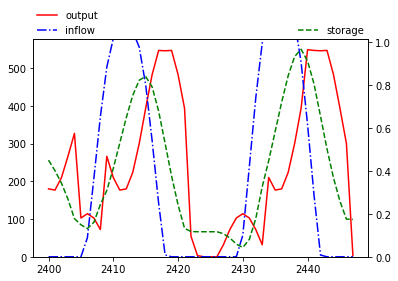

In [14]:
# CASE 4: CSP with storage (eliminating load shedding), time-dependent

# Increased generation capacity
data.generator.loc[4,'storagevalue_profile_filling']='const'
data.generator.loc[4,'storagevalue_profile_time']='csp2'
 
lp = powergama.LpProblem(data)
res = powergama.Results(data,"results.sqlite3",replace=True)

start_time = time.time()
lp.solve(res)
end_time = time.time()
print("\nSimulation time = {:.2f} seconds".format(end_time - start_time))

systemcost = res.getSystemCost()['AREA']
print("System costs (CASE 4) = {:.2e} EUR".format(systemcost))
print("Load shedding = {:.2e}".format(sum(res.getLoadheddingInArea('AREA'))))
print("Spilled CSP inflow = {:.2e}".format(
                                    sum(res.getGeneratorSpilled(4))))

res.plotGenerationPerArea('AREA',fill=True,showTitle=False)
res.plotGeneratorOutput(4,showTitle=False)

### Case 5: CSP with storage - constant values

Computing B and DA matrices...
Creating B and DA coefficients...
Found synchronous area (size = 9), using ref node = bus1
Creating LP problem instance...
Initialising LP problem...
Replacing existing SQLite file "C:\Users\hsven\code\powergama\powergama\examples\results.sqlite3"
:) Found solver here: c:\users\hsven\bin\cbc.exe
Solving...
2% 4% 6% 8% 10% 12% 14% 16% 18% 20% 22% 25% 27% 29% 31% 33% 35% 37% 39% 41% 43% 45% 47% 50% 52% 54% 56% 58% 60% 62% 64% 66% 68% 70% 72% 75% 77% 79% 81% 83% 85% 87% 89% 91% 93% 95% 97% 100% 
Simulation time = 3.15 seconds
System costs (CASE 5) = 9.17e+04 EUR
Load shedding = 0.00e+00
Spilled CSP inflow = 0.00e+00


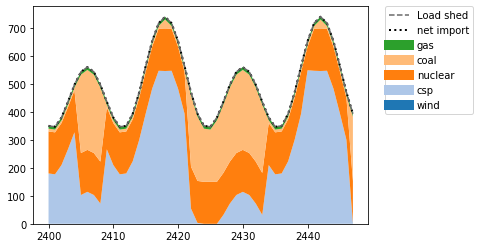

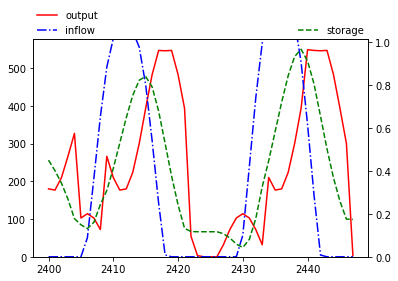

In [15]:
# CASE 5: CSP with storage - constant values

# Increased generation capacity
data.generator.loc[4,'storagevalue_profile_filling']='const'
data.generator.loc[4,'storagevalue_profile_time']='const'
 
lp = powergama.LpProblem(data)
res = powergama.Results(data,"results.sqlite3",replace=True)

start_time = time.time()
lp.solve(res)
end_time = time.time()
print("\nSimulation time = {:.2f} seconds".format(end_time - start_time))

systemcost = res.getSystemCost()['AREA']
print("System costs (CASE 5) = {:.2e} EUR".format(systemcost))
print("Load shedding = {:.2e}".format(sum(res.getLoadheddingInArea('AREA'))))
print("Spilled CSP inflow = {:.2e}".format(
                                    sum(res.getGeneratorSpilled(4))))

res.plotGenerationPerArea('AREA',fill=True,showTitle=False)
res.plotGeneratorOutput(4,showTitle=False)

## Case 6: Flexible demand

This case illustrates flexible demand using storage values

Computing B and DA matrices...
Creating B and DA coefficients...
Found synchronous area (size = 9), using ref node = bus1
Creating LP problem instance...
Initialising LP problem...
Replacing existing SQLite file "C:\Users\hsven\code\powergama\powergama\examples\results.sqlite3"
:) Found solver here: c:\users\hsven\bin\cbc.exe
Solving...
2% 4% 6% 8% 10% 12% 14% 16% 18% 20% 22% 25% 27% 29% 31% 33% 35% 37% 39% 41% 43% 45% 47% 50% 52% 54% 56% 58% 60% 62% 64% 66% 68% 70% 72% 75% 77% 79% 81% 83% 85% 87% 89% 91% 93% 95% 97% 100% 
Simulation time = 3.82 seconds
System costs (CASE 6) = 1.49e+05 EUR
Load shedding = 0.00e+00
Spilled CSP inflow = 2.49e+03


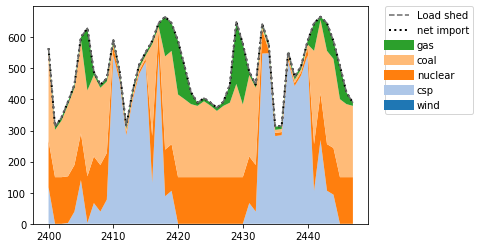

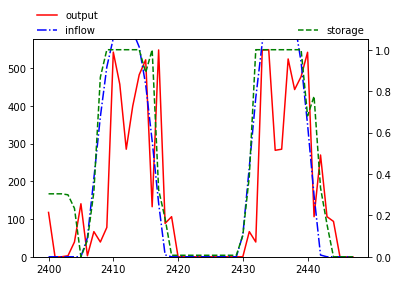

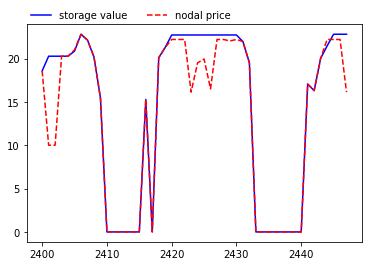

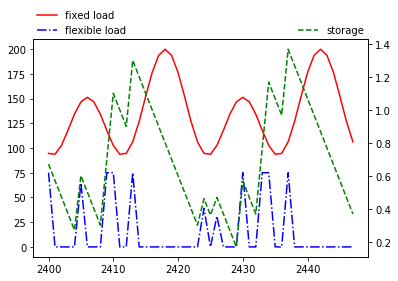

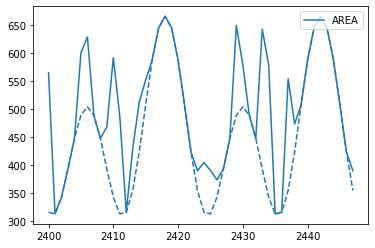

In [16]:
# CASE 6: Less storage + flexible demand

# Increased generation capacity
data.generator.loc[4,'storval_filling_ref']='csp2'
data.generator.loc[4,'storval_time_ref']='const'
data.generator.loc[4,'storage_price']=19
data.generator.loc[4,'storage_cap']=600*1 # no storage - cf CASE 2
numCons=data.numConsumers()
data.consumer['flex_basevalue'] = [10]*numCons
data.consumer['flex_fraction'] = [0.10]*numCons
data.consumer['flex_on_off'] = [0.2]*numCons
data.consumer['flex_storage'] = [10]*numCons # 6 hours
data.consumer['flex_storagelevel_init'] = (0.2+0.6*np.random.rand(numCons)).tolist()
data.consumer['flex_storval_filling'] = ['flexdemand']*numCons
data.consumer['flex_storval_time'] = ['const']*numCons
 
lp = powergama.LpProblem(data)
res = powergama.Results(data,"results.sqlite3",replace=True)

start_time = time.time()
lp.solve(res)
end_time = time.time()
print("\nSimulation time = {:.2f} seconds".format(end_time - start_time))

systemcost = res.getSystemCost()['AREA']
print("System costs (CASE 6) = {:.2e} EUR".format(systemcost))
print("Load shedding = {:.2e}".format(sum(res.getLoadheddingInArea('AREA'))))
print("Spilled CSP inflow = {:.2e}".format(
                                    sum(res.getGeneratorSpilled(4))))

res.plotGenerationPerArea('AREA',fill=True,showTitle=False)
res.plotGeneratorOutput(4,showTitle=False)
res.plotStorageValues(4,showTitle=False)
res.plotDemandAtLoad(0,showTitle=False)
res.plotDemandPerArea(['AREA'],showTitle=False)
